# 07. 리샘플링 & 모델평가

In [2]:
library(tidyverse)
library(tidymodels)
ggplot2::theme_set(theme_bw())
tidymodels_prefer()

In [3]:
data(ames)
ames <- mutate(ames, Sale_Price = log10(Sale_Price))

set.seed(502)
ames_split <- initial_split(ames, prop = 0.80, strata = Sale_Price)
ames_train <- training(ames_split)
ames_test  <-  testing(ames_split)

<br>

## 07.01. 제대체 (Resubstitution)
- **훈련에 사용한 것과 동일한 데이터(새 데이터나 테스트 데이터가 아님)에 대한 성능을 측정할 때 데이터의 제대체**


<br>

### 선형회귀 모델
- 선형회귀 모델 정의

In [4]:
lm_model <- linear_reg() %>% set_engine("lm")

<br>

- 워크플로 생성

In [5]:
lm_wflow <- workflow() %>% 
  add_formula(
    Sale_Price ~ Neighborhood + Gr_Liv_Area + Year_Built + Bldg_Type + Latitude + Longitude) %>% 
  add_model(lm_model) 

<br>

- 모델 적합

In [6]:
lm_fit <- fit(lm_wflow, ames_train)

<br>

### 랜덤포레스트 모델
- 랜덤포레스트 모델 정의

In [7]:
rf_model <- rand_forest(trees = 1000) %>% 
  set_engine("ranger") %>% 
  set_mode("regression")

<br>

- 워크플로 생성

In [8]:
rf_wflow <- workflow() %>% 
  add_formula(
    Sale_Price ~ Neighborhood + Gr_Liv_Area + Year_Built + Bldg_Type + Latitude + Longitude) %>% 
  add_model(rf_model) 

- 모델 적합

In [9]:
rf_fit <- rf_wflow %>% fit(data = ames_train)

<br>

### 모델 비교
- 예측을 생성하고 결과형식을 지정하는 함수

In [10]:
estimate_perf <- function(model, dat) {

  cl <- match.call()
  obj_name <- as.character(cl$model)
  data_name <- as.character(cl$dat)
  data_name <- gsub("ames_", "", data_name)
  
  reg_metrics <- metric_set(rmse, rsq)
  
  model %>%
    predict(dat) %>%
    bind_cols(dat %>% select(Sale_Price)) %>%
    reg_metrics(Sale_Price, .pred) %>%
    select(-.estimator) %>%
    mutate(object = obj_name, data = data_name)
}

<br>

- **랜덤포레스트 모델이 선형회귀 모델보다 좋은 성능**

In [11]:
estimate_perf(rf_fit, ames_train)

.metric,.estimate,object,data
<chr>,<dbl>,<chr>,<chr>
rmse,0.0364104,rf_fit,train
rsq,0.9601284,rf_fit,train


In [12]:
estimate_perf(lm_fit, ames_train)

Warning message in predict.lm(object = object$fit, newdata = new_data, type = "response", :
"prediction from rank-deficient fit; consider predict(., rankdeficient="NA")"


.metric,.estimate,object,data
<chr>,<dbl>,<chr>,<chr>
rmse,0.08151325,lm_fit,train
rsq,0.78499440,lm_fit,train


<br>

### 모델 평가
- 테스트 데이터에 대한 평가결과는 훈련 데이터보다 나쁜 성능을 보임

In [13]:
estimate_perf(rf_fit, ames_test)

.metric,.estimate,object,data
<chr>,<dbl>,<chr>,<chr>
rmse,0.07037264,rf_fit,test
rsq,0.85184851,rf_fit,test


<br>

### 편향
- **편향은 데이터의 실제 패턴과 모델이 적합할 수 있는 패턴 유형간의 차이**
    - 많은 기계 학습 모델은 편향이 낮아 복잡한 관계를 재현할 수 있음
    
- 편향이 낮은 모델의 경우, 높은 수준의 예측력으로 인해 모델이 훈련 데이터의 세트에 과적합될 수 있음
    - 훈련 데이터에 대한 예측 성능을 가지지만, 테스트 데이터에 대해서는 그렇지 않음
    
    $\rightarrow$ **리샘플링의 필요성**

<br>

## 07.02. 리샘플링
- **리샘플링은 모델링을 위해 일부 데이터를 사용하고, 평가를 위해 다른 데이터를 사용하는 프로세스를 모델 적합에 사용하는 경험적 시뮬레이션 시스템**
    - 대부분의 리샘플링 방법은 반복적
    
<br>

<img src = 'https://www.tmwr.org/premade/resampling.svg'>

<br>

- **리샘플링은 훈련 데이터에 대해서만 수행 (테스트 데이터에는 수행 X)**
- **리샘플링이 반복될 때 마다 데이터는 두 개의 하위 샘플로 분할**
    - **모델이 훈련 데이터에 적합**
    - **모델은 검증 데이터를 사용하여 평가**
    
<br>

- 20번의 리샘플링 반복이 수행되었다고 가정 시,
    
    20개의 개별 모델이 훈련 데이터에 적합하고, 
    
    해당 검증 데이터가 가 20개의 성능 통계 세트를 생성한다는 것을 의미
    
    <br>
    
    - 모델 성능의 최종 추정치는 20번의 통계 반복실험의 평균
        - 이 평균은 매우 좋은 일반화 특성을 가지며 재대체 추정치보다 대체로 좋음

<br>

### 교차 검증
- **가장 일반적인 교차 검증 방법은 K-fold 교차 검증**
- **데이터는 동일한 크기의 $K$개 세트로 무작위 분할**

<img src= 'https://www.tmwr.org/premade/three-CV.svg'>

<br>

- **3-fold 교차 검증의 경우, 각 반복마다 평가지표 생성을 위해,**
    
    **1개의 fold는 검증용 데이터로, 나머지 2개는 훈련용 데이터로 사용**
    
    - **이 프로세스는 각 fold에 대해 반복 $\rightarrow$ 3가지 모델이 각각 성능 지표를 계산**
    
<br>

<img src='https://www.tmwr.org/premade/three-CV-iter.svg'>

<br>

- **fold의 개수는 대체로 5 or 10**
- **fold의 개수가 클수록 편향은 작지만 분산이 큰 결과**
    
    **fold의 개수가 작을수록 편향은 크지만 분산은 낮은 결과**
    
<br>

#### `vfold_cv(데이터, v, repeats)`
- **`v`** : fold 개수
- **`repeats`** : 반복 횟수

In [14]:
set.seed(1001)
ames_folds <- vfold_cv(ames_train, v = 10)

- 첫 번째 fold에는 2342개의 전체 데이터 중, 2107개의 훈련용 데이터와, 235개의 검증용 데이터가 존재

In [15]:
ames_folds$splits[[1]]

<Analysis/Assess/Total>
<2107/235/2342>

- 첫 번째 fold의 훈련용 데이터

In [16]:
ames_folds$splits[[1]] %>% analysis() %>% dim
ames_folds$splits[[1]] %>% analysis() %>% head

[1] 2107   74

MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,⋯,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude
<fct>,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,70,8400,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,⋯,Minimum_Privacy,None,0,4,2010,WD,Normal,5.100371,-93.62711,42.05340
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,70,10500,Pave,No_Alley_Access,Regular,Lvl,AllPub,FR2,⋯,No_Fence,None,0,4,2010,ConLI,Normal,5.060698,-93.62277,42.05638
Two_Story_PUD_1946_and_Newer,Residential_Medium_Density,21,1680,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,⋯,No_Fence,None,0,3,2010,WD,Normal,5.023252,-93.62754,42.05168
Two_Story_PUD_1946_and_Newer,Residential_Medium_Density,21,1680,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,⋯,No_Fence,None,0,3,2010,WD,Family,4.944483,-93.62728,42.05168
One_Story_PUD_1946_and_Newer,Residential_Low_Density,53,4043,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,⋯,No_Fence,None,0,7,2010,WD,Normal,5.105510,-93.62723,42.04967
One_Story_PUD_1946_and_Newer,Residential_Low_Density,24,2280,Pave,No_Alley_Access,Regular,Lvl,AllPub,FR2,⋯,No_Fence,None,0,6,2010,WD,Normal,5.079181,-93.62597,42.05068


<br>

### 반복된 교차 검증
- **교차 검증의 가장 중요한 변형은 반복적인 K-fold 교차 검증**
- **데이터 크기나 기타 특성에 따라 K-fold 교차 검증으로 생성된 리샘플링 추정값에는 노이즈가 존재할 수 있음**
    
    $\rightarrow$ **많은 통계 문제와 마찬가지로 노이즈를 줄이는 한 가지 방법은 더 많은 데이터를 수집하는 것**

    $\rightarrow$ **교차 검증의 경우 이는 K-fold 통계 이상의 평균을 의미**

- **K-fold 교차 검증의 R번 반복을 생성하려면, 동일한 fold 생성 프로세스가 R 번 수행되어 K개의 분할에 대한 R개의 컬렉션을 생성**
    
    $\rightarrow$ $V\times R$개의 많은 개수의 평가지표들은 중심극한정리로 인해 정규 분포를 따르는 경향이 존재
    
    - 위의 데이터에서 10-fold 생성을 통해, 각 fold는 평균적으로 234개의 검증용 데이터를 사용
    
    - 평가지표가 RMSE이고, 평가지표의 모표준편차를 $\sigma$라고 한다면
    
        10-fold 교차검증은 10개의 표본을 의미하므로, RMSE의 표준오차는 $\frac{\sigma}{\sqrt{10}}$
        
        또한 10-fold 교차검증을 $R$번 반복하였다면 표준오차는 $\frac{\sigma}{\sqrt{10 R}}$
        
    - 아래의 그림은 반복 교차 검증을 통한 표준오차 감소량
        - 교차 검증의 반복횟수가 증가할수록, 표준 오차의 감소폭이 감소
    
<br>

<img src='https://www.tmwr.org/figures/variance-reduction-1.png'>

In [17]:
folds_ = vfold_cv(ames_train, v = 10, repeats = 5)

<br>

### LOOCV (Leave One Out Cross Validation)
- **$N$의 크기를 가진 데이터에서, $N-1$개의 값을 훈련 데이터로, 나머지 1개를 검증용 데이터로 사용**
    
    $\rightarrow$ **총 $N$개의 모델 생성**
    
- 데이터의 크기가 작지 않으면, LOOCV는 과도한 계산량을 유발하며, 좋은 통계적 특성을 가지지 못함

<br>

### MCCV (몬테카를로 교차 검증, Monte Carlo Cross Validation)
- K-fold 교차 검증의 또 다른 변형
- **K-fold 교차 검증과 마찬가지로 특정 비율의 데이터를 검증용 데이터에 할당**
    - **하지만 이 비율은 매번 무작위로 선택되며, 상호 배타적이지 않은 검증용 데이터가 생성**

<br>

#### `mc_cv(데이터, prop, times)`
- **`prop`** : 훈련 데이터 비율
- **`times`** : fold 개수

In [18]:
mc_cv_ = mc_cv(ames_train, prop = 9/10, times = 20)

<br>

### 검증 데이터
- 일반적인 데이터 분할 구조

<img src='https://www.tmwr.org/premade/validation.svg'>

<br>

- 교차 검증 데이터 분할 구조

#### `initial_validation_split(데이터, prop = c(훈련비율, 검증비율))`

<br>

<img src='https://www.tmwr.org/premade/validation-alt.svg'>

In [19]:
set.seed(52)

ames_val_split <- initial_validation_split(ames, prop = c(0.6, 0.2))
ames_val_split

<Training/Validation/Testing/Total>
<1758/586/586/2930>

In [21]:
val_set <- validation_set(ames_val_split)
val_set$splits

[[1]]
<Training/Validation/Total>
<1758/586/2344>


<br>

### 부트스트래핑
- 부트스트랩 리샘플링은 원래 이론적 특성이 다루기 힘든 통계의 샘플링 분포를 근사화하기 위한 방법으로 발명 (Davison and Hinkley 1997)

- **일부 훈련 데이터가 분석 세트에 대해 여러 번 선택되는 복원 추출**
- 각 데이터는 훈련 데이터에 한 번 이상 포함될 확률이 63.2%이며, 검증 데이터에는 분석 세트에 대해 선택되지 않은 모든 훈련 세트 샘플이 포함 (평균적으로 훈련 세트의 36.8% 포함). 
    - 부트스트래핑할 때 평가 세트를 Out-of-bag 샘플이라고 부름

<br>

- 30개 샘플로 구성된 훈련 데이터에서 3개의 부트스트랩 샘플

<img src='https://www.tmwr.org/premade/bootstraps.svg'>

<br>

#### `bootstraps(데이터, times)`

In [24]:
bs_ = bootstraps(ames_train, times=5)
bs_$splits

[[1]]
<Analysis/Assess/Total>
<2342/854/2342>

[[2]]
<Analysis/Assess/Total>
<2342/874/2342>

[[3]]
<Analysis/Assess/Total>
<2342/889/2342>

[[4]]
<Analysis/Assess/Total>
<2342/865/2342>

[[5]]
<Analysis/Assess/Total>
<2342/847/2342>


<br>

- **부트스트랩 샘플은 분산이 매우 낮지만 상당한 비관적 편향이 있는 성능 추정치를 생성**

    **이는 모델의 실제 정확도가 90%인 경우 부트스트랩이 값을 90% 미만으로 추정하는 경향이 있음을 의미**
- 성능 지표의 규모에 따라 편향의 정도가 달라질 수 있음
    - 정확도가 90%일 때와 70%일 때 편향이 다를 가능성이 높음

- 부트스트랩은 많은 모델 내부에서도 사용
    - 랜덤 포레스트 모델에는 1,000개의 개별 의사결정 트리가 포함되어 있으며, 각 트리는 훈련 데이터의 각각 다른 부트스트랩 샘플로 생성



<br>

### 롤링 리샘플링 (ROLLING FORECASTING ORIGIN RESAMPLING)
- **데이터에 시계열 요소가 있는 경우, 리샘플링 방법은 데이터 내의 계절적 추세 및 기타 시간적 추세를 추정하기 위한 모델링을 지원해야하며, 훈련 데이터에서 값을 무작위로 샘플링하는 기술은 이러한 패턴을 추정하는 모델의 기능을 방해할 수 있음**

    $\rightarrow$ **롤링 리샘플링 (Hyndman 및 Athanasopoulos 2018)은 실제로 시계열 데이터가 분할되는 방식으로 과거 데이터로 모델을 추정하고 최신 데이터로 평가하는 방법을 제공**
    
    **이러한 유형의 리샘플링의 경우 초기 분석 및 검증용 데이터의 크기가 지정**
    
    **리샘플링의 첫 번째 반복에서는 계열의 시작 부분부터 이러한 크기를 사용**
    
    **두 번째 반복에서는 동일한 데이터 크기를 사용하지만 설정된 샘플 수만큼 이동**
  
<br>

- 15의 크기를 가진 데이터에서, 훈련 데이터가 8개이고, 3의 크기를 가진 검증용 데이터의 리샘플링
    - 두 번째 반복에서는 첫 번째 값 (1)을 버리고, 훈련용 데이터와 검증용 데이터 모두 앞으로 한 칸씩 이동
    
<img src='https://www.tmwr.org/premade/rolling.svg'>

<br>

- **훈련용 데이터는 (동일한 크기를 유지하는 것과는 반대로) 누적될 수 있음**
    - 첫 번째 초기 데이터 이후에는 이전 데이터를 삭제하지 않고도 새 샘플이 누적될 수 있음

- 리샘플링 이동 간격은, 대규모 데이터 세트의 경우 증분 블록은 하루(1)가 아닌 주 또는 월이 될 수 있음



<br>

#### `rolling_origin()`

- 1년치의 데이터에 대해, 30크기의 검증용 데이터, 30의 리샘플링 이동 간격

In [25]:
time_slices <- 
  tibble(x = 1:365) %>% 
  rolling_origin(initial = 6 * 30, assess = 30, skip = 29, cumulative = FALSE)

In [42]:
data_range <- function(x) {
  summarize(x, first = min(x), last = max(x))
}

In [43]:
map_dfr(time_slices$splits, ~   analysis(.x) %>% data_range())

first,last
<int>,<int>
1,180
31,210
61,240
91,270
121,300
151,330


In [44]:
map_dfr(time_slices$splits, ~ assessment(.x) %>% data_range())

first,last
<int>,<int>
181,210
211,240
241,270
271,300
301,330
331,360


<br>

## 07.03. 성능 추정

<br>

#### 리샘플링 사용 프로세스
- 리샘플링 과정에서의 훈련용 데이터는 데이터를 전처리하고, 자체적으로 전처리를 적용하고, 처리된 데이터를 사용하여 모델을 적합하는 데 사용
- 분석 세트에서 생성된 전처리 통계량은 검증용 데이터에도 적용. 검증용 데이터에서의 예측은 새 데이터에 대한 성능을 추정
- 이 시퀀스는 모든 리샘플링마다 반복
    - $B$개의 리샘플이 있는 경우, 각 성능 지표에 대한 $B$개의 반복
    - 최종 리샘플링 추정치는 $B$개의 통계량의 평균
    - $B=1$인 경우, 전체 성능을 의미
    

<br>

#### `fit_resamples(resamples, control)` : 모델 워크플로에 리샘플링 적용
- **`control`** : 리샘플링 옵션 설정, `control_resamples()` 함수로 설정
- 리샘플링 성능은 회귀에서는 RMSE, $R^2$를 사용, 분류모델은 AUC를 사용

<br>

#### `control_resamples(save_pred, save_workflow)` : 리샘플링 옵션 객체 생성

In [48]:
keep_pred <- control_resamples(save_pred = T, save_workflow = T)

<br>

#### K-fold에 대한 리샘플링 적용

In [58]:
ames_folds$splits[[1]]
ames_folds$splits %>% length

<Analysis/Assess/Total>
<2107/235/2342>

[1] 10

In [49]:
set.seed(1003)
rf_res <- rf_wflow %>%
    fit_resamples(resamples = ames_folds, control = keep_pred)

- 각 리샘플에서 훈련용 데이터의 성능 통계량

In [54]:
rf_res$.metrics[[1]]

.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
rmse,standard,0.06048913,Preprocessor1_Model1
rsq,standard,0.86153160,Preprocessor1_Model1


- 리샘플링 중에 생성된 경고 또는 오류 목록

In [56]:
rf_res$.notes[[1]]

location,type,note
<chr>,<chr>,<chr>


- 각 리샘플에서 검증용 데이터에 대한 예측값. `control_resamples()`의 `save_pred = TRUE`일 때에 생성

In [60]:
rf_res$.predictions[[1]] %>% dim
rf_res$.predictions[[1]] %>% head

[1] 235   4

.pred,.row,Sale_Price,.config
<dbl>,<int>,<dbl>,<chr>
5.100795,10,5.086360,Preprocessor1_Model1
4.920386,27,4.903090,Preprocessor1_Model1
5.205546,47,5.084576,Preprocessor1_Model1
5.129049,52,5.103804,Preprocessor1_Model1
5.132585,59,5.097604,Preprocessor1_Model1
5.130911,63,5.107210,Preprocessor1_Model1


<br>

#### `collect_metrics()` : 성능 통계량 요약
- 개별 반복에 대한 성능 통계량

In [65]:
collect_metrics(rf_res, summarize = T)

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
rmse,standard,0.07209269,10,0.003054732,Preprocessor1_Model1
rsq,standard,0.83132795,10,0.010800604,Preprocessor1_Model1


- 각 리샘플에 대한 성능 통계량

In [66]:
collect_metrics(rf_res, summarize = F)

id,.metric,.estimator,.estimate,.config
<chr>,<chr>,<chr>,<dbl>,<chr>
Fold01,rmse,standard,0.06048913,Preprocessor1_Model1
Fold01,rsq,standard,0.86153160,Preprocessor1_Model1
Fold02,rmse,standard,0.06532037,Preprocessor1_Model1
Fold02,rsq,standard,0.86147309,Preprocessor1_Model1
Fold03,rmse,standard,0.06090805,Preprocessor1_Model1
Fold03,rsq,standard,0.88033562,Preprocessor1_Model1
Fold04,rmse,standard,0.06992806,Preprocessor1_Model1
Fold04,rsq,standard,0.81789390,Preprocessor1_Model1
Fold05,rmse,standard,0.07379762,Preprocessor1_Model1


<br>

#### `collect_predictions()` : 검증용 데이터에 대한 예측값 확인

In [79]:
assess_res <- collect_predictions(rf_res, summarize = T)
assess_res %>% head

.row,Sale_Price,.config,.pred
<int>,<dbl>,<chr>,<dbl>
1,5.100371,Preprocessor1_Model1,4.999708
2,5.060698,Preprocessor1_Model1,5.066534
3,5.023252,Preprocessor1_Model1,4.978509
4,4.944483,Preprocessor1_Model1,5.017363
5,5.105510,Preprocessor1_Model1,5.148340
6,5.079181,Preprocessor1_Model1,5.109061


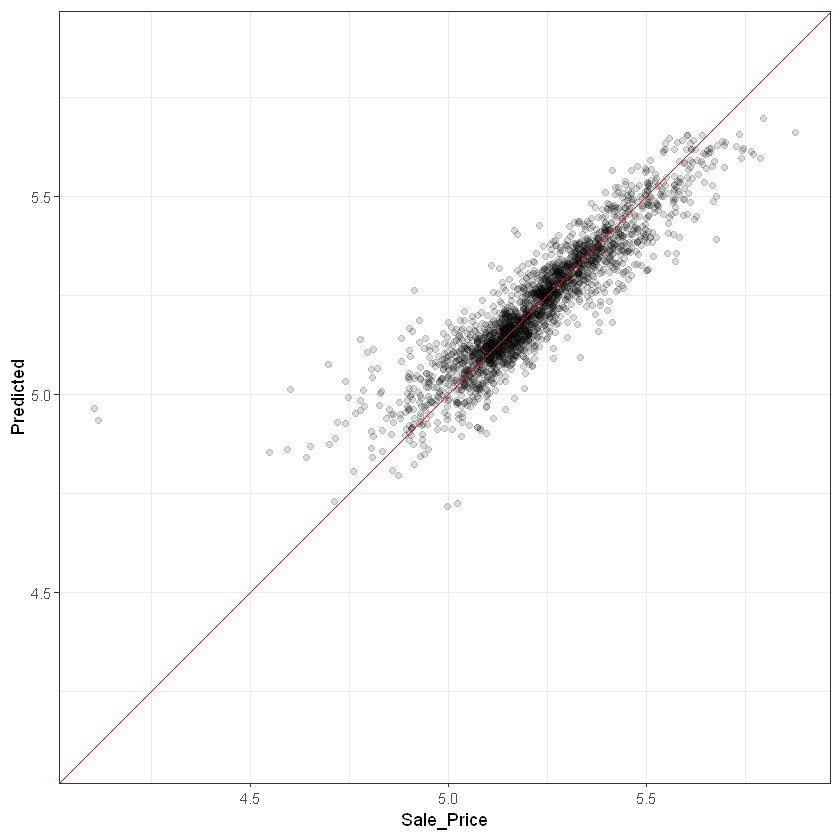

In [80]:
assess_res %>% 
    ggplot(aes(x = Sale_Price, y = .pred)) + 
    geom_point(alpha = .15) +
    geom_abline(color = "red") + 
    coord_obs_pred() + 
    ylab("Predicted")

* 과대 예측값 2개

In [85]:
over_predicted <- 
    assess_res %>% 
    mutate(residual = Sale_Price - .pred) %>% 
    arrange(desc(abs(residual))) %>% 
    head(2)

over_predicted %>% head

.row,Sale_Price,.config,.pred,residual
<int>,<dbl>,<chr>,<dbl>,<dbl>
32,4.106837,Preprocessor1_Model1,4.964866,-0.8580290
317,4.117271,Preprocessor1_Model1,4.932895,-0.8156234


In [86]:
ames_train %>% 
    slice(over_predicted$.row) %>% 
    select(Gr_Liv_Area, Neighborhood, Year_Built, Bedroom_AbvGr, Full_Bath)

Gr_Liv_Area,Neighborhood,Year_Built,Bedroom_AbvGr,Full_Bath
<int>,<fct>,<int>,<int>,<int>
832,Old_Town,1923,2,1
733,Iowa_DOT_and_Rail_Road,1952,2,1


- 부트스트랩 또는 반복 교차 검증과 같은 일부 리샘플링 방법의 경우, 각 리샘플별 예측값

In [77]:
collect_predictions(rf_res, summarize = F) %>% head

id,.pred,.row,Sale_Price,.config
<chr>,<dbl>,<int>,<dbl>,<chr>
Fold01,5.100795,10,5.086360,Preprocessor1_Model1
Fold01,4.920386,27,4.903090,Preprocessor1_Model1
Fold01,5.205546,47,5.084576,Preprocessor1_Model1
Fold01,5.129049,52,5.103804,Preprocessor1_Model1
Fold01,5.132585,59,5.097604,Preprocessor1_Model1
Fold01,5.130911,63,5.107210,Preprocessor1_Model1


<br>

#### K-fold가 아닌 전체 훈련/검증/테스트 세트 적용

In [88]:
val_set$splits

[[1]]
<Training/Validation/Total>
<1758/586/2344>


In [95]:
val_res <- rf_wflow %>% fit_resamples(resamples = val_set)

Warning message in `[.tbl_df`(x, is.finite(x <- as.numeric(x))):
"NAs introduced by coercion"


In [96]:
collect_metrics(val_res)

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
rmse,standard,0.07302945,1,NA,Preprocessor1_Model1
rsq,standard,0.82123925,1,NA,Preprocessor1_Model1


<br>

## 07.04. 리샘플링된 객체 저장
- 리샘플링 중에 생성된 모델은 유지되지 않으며, 성능 평가 목적으로 훈련되었기에 일반적으로 성능 통계량을 계산한 후에는 필요하지 않음
- 특정 파라미터가 최적의 하이퍼 파라미터로 판명되면, 최선의 선택은 더 많은 데이터로 모델 파라미터를 추정할 수 있도록 전체 훈련 세트에 다시 적합하는 것

- 리샘플링 중에 생성된 이러한 모델은 보존되지 않지만, 해당 모델 또는 해당 구성 요소 중 일부를 유지하는 방법
    - **`control_resamples()`의 `extract`**

<br>

#### 선형 회귀 모델 적합 예시
- 데이터 전처리

In [101]:
ames_rec <- recipe(Sale_Price ~ Neighborhood + Gr_Liv_Area + Year_Built + Bldg_Type + Latitude + Longitude, data = ames_train) %>%
    step_other(Neighborhood, threshold = 0.01) %>% 
    step_dummy(all_nominal_predictors()) %>% 
    step_interact( ~ Gr_Liv_Area:starts_with("Bldg_Type_") ) %>% 
    step_ns(Latitude, Longitude, deg_free = 20)

- 워크플로 생성

In [102]:
lm_wflow <- workflow() %>% 
    add_recipe(ames_rec) %>% 
    add_model(linear_reg() %>% set_engine("lm"))

- 데이터 적합

In [103]:
lm_fit <- lm_wflow %>% fit(data = ames_train)

- 워크플로 확인

In [106]:
extract_recipe(lm_fit, estimated = T)



── Recipe ──────────────────────────────────────────────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 6



── Training information 

Training data contained 2342 data points and no incomplete rows.



── Operations 

• Collapsing factor levels for: Neighborhood | Trained

• Dummy variables from: Neighborhood and Bldg_Type | Trained

• Interactions with: Gr_Liv_Area:(Bldg_Type_TwoFmCon + Bldg_Type_Duplex + Bldg_Type_Twnhs + Bldg_Type_TwnhsE) | Trained

• Natural splines on: Latitude and Longitude | Trained



- **워크플로에서 적합된 모델의 가중치를 저장하는 함수**

In [107]:
get_model <- function(x) {extract_fit_parsnip(x) %>% tidy()}

In [109]:
get_model(lm_fit) %>% head()

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.5413027754,2.984135e-01,5.16499087,2.614068e-07
Gr_Liv_Area,0.0001625191,4.460054e-06,36.43880590,2.812458e-229
Year_Built,0.0017714469,1.401481e-04,12.63981975,1.934790e-35
Neighborhood_College_Creek,0.0012477682,3.496193e-02,0.03568933,9.715332e-01
Neighborhood_Old_Town,-0.0718270370,1.294045e-02,-5.55058215,3.179224e-08
Neighborhood_Edwards,-0.0956970030,2.926933e-02,-3.26953185,1.093362e-03


<br>

- **10번의 리샘플링에서 발생된 각 모델의 가중치를 저장**

In [112]:
ctrl <- control_resamples(extract = get_model)

In [113]:
lm_res <- lm_wflow %>%  fit_resamples(resamples = ames_folds, control = ctrl)

- 첫 리샘플링에서 생성된 모델의 가중치

In [120]:
lm_res$.extracts[[1]][[1]][[1]] %>% head

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.4760597162,3.196061e-01,4.61837193,4.109482e-06
Gr_Liv_Area,0.0001580881,4.758151e-06,33.22469868,9.724278e-194
Year_Built,0.0017992414,1.488582e-04,12.08694982,1.567674e-32
Neighborhood_College_Creek,-0.0016341284,3.734748e-02,-0.04375472,9.651042e-01
Neighborhood_Old_Town,-0.0756810364,1.382365e-02,-5.47475194,4.922902e-08
Neighborhood_Edwards,-0.1093650469,3.095808e-02,-3.53268235,4.205378e-04


- 두 번째 리샘플링에서 생성된 모델의 가중치

In [128]:
lm_res$.extracts[[2]][[1]][[1]] %>% head

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.543593023,3.206827e-01,4.813459,1.592585e-06
Gr_Liv_Area,0.000164538,4.902043e-06,33.565196,5.986204e-197
Year_Built,0.001802561,1.506935e-04,11.961773,6.445008e-32
Neighborhood_College_Creek,-0.044738016,3.681485e-02,-1.215217,2.244245e-01
Neighborhood_Old_Town,-0.072320903,1.392799e-02,-5.192486,2.281864e-07
Neighborhood_Edwards,-0.124412608,3.083696e-02,-4.034529,5.673329e-05


- 모든 10번의 리샘플링에서의 가중치 추출

In [125]:
all_coef <- map_dfr(lm_res$.extracts, ~ .x[[1]][[1]])

In [129]:
all_coef %>% filter(term == "(Intercept)")

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.476060,0.3196061,4.618372,4.109482e-06
(Intercept),1.543593,0.3206827,4.813459,1.592585e-06
(Intercept),1.377211,0.3179111,4.332064,1.549049e-05
(Intercept),1.461967,0.3125498,4.677549,3.093943e-06
(Intercept),1.484782,0.3210432,4.624866,3.983870e-06
(Intercept),1.474589,0.3187650,4.625942,3.963449e-06
(Intercept),1.512997,0.3184701,4.750827,2.167359e-06
(Intercept),1.424333,0.3081724,4.621872,4.041319e-06
(Intercept),1.927639,0.3139182,6.140577,9.859717e-10
